## Code for Runoff analysis over CONUS404 based estimation in comparison with USGS-CAMELS datasets

### Author: Miguel Diaz

#### **Libraries**

!pip install absl-py apache-beam xarray xarray-beam earthengine-api geemap pyproj geopandas pandas numpy sparse hvplot holoviews dask cf-xarray geoviews pynhd hydrofunctions intake cartopy shapely matplotlib contextily scipy rasterio requests IPython
!pip install notebook
!earthengine authenticate
!pip install dask[distributed]
!pip install bokeh
!pip install xee
!pip install datashader

!pip install zarr
!pip install fsspec gcsfs s3fs
!pip install --upgrade intake
!pip install zarr intake intake-xarray fsspec s3fs gcsfs
!pip install --upgrade intake intake-xarray zarr
!pip install metpy

!pip install --upgrade xarray metpy
!pip install scikit-learn
!pip install apache-beam
!pip install cf_xarray

In [1]:
import logging
import os
import time
import warnings
import webbrowser

# Data handling and computation
import numpy as np
import pandas as pd
import xarray as xr
import cf_xarray
import dask
import dask.array as da
from dask import delayed
from dask.distributed import Client
import sparse

# Scientific libraries
import pyproj
from scipy.stats import linregress, gumbel_r

# GIS and remote sensing
import geopandas as gpd
import geemap
import ee
import xarray_beam as xbeam
import apache_beam as beam
import xee
import zarr

# Mapping and visualization
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
from holoviews.operation.datashader import rasterize
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

# Geospatial libraries
from shapely.geometry import Polygon
from rasterio.enums import Resampling

# Hydrology and water data
from pynhd import NLDI, WaterData
import hydrofunctions as hf

# Data intake and registry
import intake
print(intake.registry)

# Meteorology and weather data
from metpy.units import units
import metpy  # Ensure this is imported to extend xarray

# Web and API requests
import requests
from IPython.display import HTML

# ABSL (Google's command-line flags and app framework)
from absl import app, flags

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline


<Intake driver registry>


#### **CONUS 404 - SOURCES**

This section contains notebooks that demonstrate how to access and perform basic data manipulation for the [CONUS404 dataset](https://doi.org/10.5066/P9PHPK4F). The examples can also be applied to the [CONUS404 bias-adjusted dataset](https://doi.org/10.5066/P9JE61P7).

In the CONUS404 intake sub-catalog (see [here](../dataset_catalog/README.md) for an explainer of our intake data catalog), you will see entries for four CONUS404 datasets: `conus404-hourly`, `conus404-daily`, `conus404-monthly`, and `conus404-daily-diagnostic` data, as well as two CONUS404 bias-adjusted datasets: `conus404-hourly-ba`, `conus404-daily-ba`. Each of these datasets is duplicated in up to three different storage locations (as the [intake catalog section](../dataset_catalog/README.md) also describes).

In the CONUS404 intake sub-catalog (see [here](../dataset_catalog/README.md) for an explainer of our intake data catalog), you will see entries for:
- four CONUS404 datasets: `conus404-hourly`, `conus404-daily`, `conus404-monthly`, and `conus404-daily-diagnostic` data
- two CONUS404 bias-adjusted datasets: `conus404-hourly-ba`, `conus404-daily-ba`
- two CONUS404 PGW datasets: `conus404-pgw-hourly` and `conus404-pgw-daily-diagnostic`

#### **Dask client with specified number of workers**

In [2]:
client = Client(n_workers=4)  
client

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51859 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:51863' processes=4 threads=32, memory=127.69 GiB>

Open the hytest data intake catalog


In [7]:
# "https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml"
hytest_cat = intake.open_catalog("https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml")
# list(hytest_cat)

FileNotFoundError: https://raw.githubusercontent.com/hytest-org/hytest/main/dataset_catalog/hytest_intake_catalog.yml

Open the conus404 sub-catalog

In [ ]:
cat = hytest_cat['conus404-catalog']
# list(cat)

**CONUS404 dataset**

Select the dataset you want to read into your notebook and preview its metadata

In [ ]:
#  conus404-daily-osn
dataset = 'conus404-daily-osn' 
#dataset = 'nhm-v1.1-c404-bc-byHRU-onprem-hw'
cat[dataset]

In [ ]:
print(f"Reading {dataset} metadata...", end='')
ds = cat[dataset].to_dask().metpy.parse_cf()
print("done")

Select time frame to read ("CONUS404 goes from 1979 and 2021")

In [ ]:
ds_conus = ds.sel(time=slice('1989-10-01','2010-09-30')) # ========> (Water year WY1990 - WY 2010)

**Variables selection ( There is a list of variables) - (Tab ds_conus)**

ds_conus

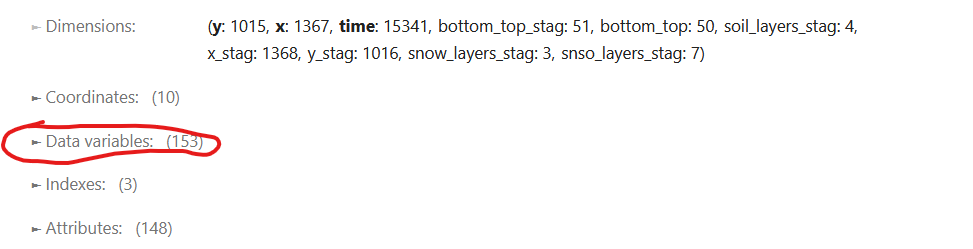
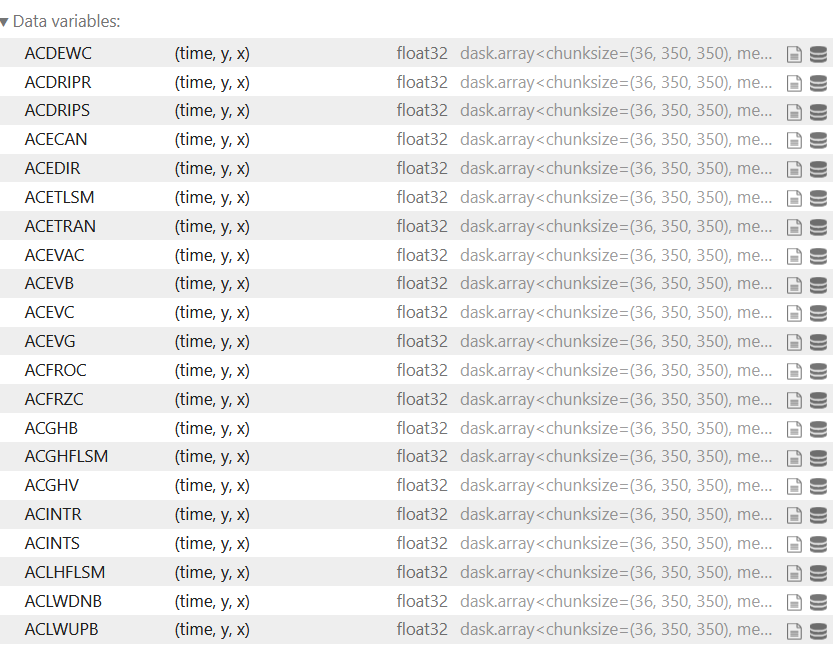

### **Model WRF CONUS404 Scheme**


In general terms for the water balance:

$$
\text{residual} = \left(P - ET - \text{srfoff} + \text{qlat} - \text{qrf} \right) - \Delta (\text{SMCWTD} + \text{SMC} + \text{CANWAT} + \text{SNOW} + \text{WA})
$$

where:

- P = total incoming precipitation  
- ET = total evapotranspiration  
- srfoff= surface runoff  
- qlat= lateral groundwater flow  
- qrf = groundwater discharge to river  
- SMCWTD = soil moisture in the auxiliary layer (between the 2-m soil layer and the groundwater)  
- SMC = soil moisture in the 2-m soil layer  
- CANWAT = water stored in the canopy  
- SNOW = snow water equivalent in the snowpack  
- WA = water stored in the aquifer  




In CONUS404 variable names:

$$
\text{residual} = \text{ACRAINLSM} + \text{ACSNOWLSM} - \text{ACECAN} - \text{ACETRAN} - \text{ACEDIR} - \text{ACRUNSF} + \text{ACQLAT} - \text{ACQRF} - \Delta(\text{QSPRINGS}) - \Delta(\text{SMCWTD}_{\text{calculated}} + \text{SMOIS}_{\text{calculated}} + \text{CANWAT} + \text{SNOW} + \text{WA}_{\text{calculated}})
$$

where:

- SMOIS_calculated is SMOIS (volumetric soi moisture content) converted to depth in mm by multiplying by soil layer depths (100mm, 300mm, 600mm, 1000mm)

- SMCWTD_calculated is the water in the zone between the 2-m soil column and the lower of the water table or the bottom of the 1-m auxiliary layer, calculated as  SMCWTD*(-2 – min(ZWT, -3))*1000

- WA_calculated is the water in the saturated zone below the auxiliary later calculated as SMCMAX*(min(ZWT, -3)-ZBEDROCK)*1000



### **Runoff Analysis**

Total runoff is ACRUNSF (quickflow-ish) + ACQRF (baseflow-ish).

In [ ]:
%%time

# # Process the dataset
# ds_conus_Runoff = ds_conus[['ACRUNSF']].resample(time="YE").sum()
# Q_Runoff = ds_conus_Runoff.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

# Select dataset within the given time range
ds_conus_Runoff = ds_conus[['ACRUNSF']]

# Resample using 'AS-OCT' to align with the water year
ds_conus_Runoff_WY = ds_conus_Runoff.resample(time="AS-OCT", label="right").sum()

# Compute the final result
Q_Runoff = ds_conus_Runoff_WY.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

In [9]:
%%time
# ds_conus_baseflow = ds_conus[['ACQRF']].resample(time="YE").sum()
# Baseflow_sub = ds_conus_baseflow.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

# Select dataset within the given time range
ds_conus_baseflow = ds_conus[['ACQRF']]

# Resample using 'AS-OCT' to align with the water year
ds_conus_baseflow_WY = ds_conus_baseflow.resample(time="AS-OCT", label="right").sum()

# Compute the final result
Baseflow_sub = ds_conus_baseflow_WY.rio.write_crs(ds_conus.crs.metpy.cartopy_crs).compute()

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\xarray\groupers.py:487: FutureWarning: 'AS-OCT' is deprecated and will be removed in a future version, please use 'YS-OCT' instead.
  self.index_grouper = pd.Grouper(


CPU times: total: 35.2 s
Wall time: 4min 5s


Visualize data computed

In [10]:
Baseflow_sub.hvplot.quadmesh(x='x', y='y', rasterize=True, geo=True, tiles='OSM', alpha=0.7, cmap='turbo')

:DynamicMap   [time]
   :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (Accumulated groundwater baseflow)

Data agregation to estimate total runoff (ACRUNSF+ ACQRF)

In [11]:
ds_subset_Runoff = Q_Runoff['ACRUNSF']
ds_subset_Baseflow = Baseflow_sub['ACQRF']

Runoff_CONUS404 = ds_subset_Runoff + ds_subset_Baseflow 

Runoff_CONUS404 = Runoff_CONUS404.to_dataset(name="Runoff") # ==> New band to store the aggregation

#### **CAMELS geometry of gages catchments from NLDI**

Initialize the NLDI service

In [5]:
nldi = NLDI()
# print(nldi)

List of gages included in CAMEL dataset

https://gdex.ucar.edu/dataset/camels/file.html 


In [8]:
gage_ids = ["01013500", "01022500", "01030500", "01031500", "01047000", "01052500", "01054200", "01055000", "01057000",
    "01073000", "01078000", "01118300", "01121000", "01123000", "01134500", "01137500", "01139000", "01139800",
    "01142500", "01144000", "01162500" , "01169000", "01170100", "01181000", "01187300", "01195100", "01333000",
    "01350000", "01350080", "01350140", "01365000", "01411300", "01413500", "01414500", "01415000", "01423000",
    "01434025", "01435000", "01439500", "01440000", "01440400", "01451800", "01466500", "01484100", "01485500",
    "01486000", "01487000", "01491000", "01510000", "01516500", "01518862", "01532000", "01539000", "01542810",
    "01543000", "01543500", "01544500", "01545600", "01547700", "01548500", "01549500", "01550000", "01552000",
    "01552500", "01557500", "01567500", "01568000", "01580000", "01583500", "01586610", "01591400", "01594950",
    "01596500", "01605500", "01606500", "01613050", "01620500", "01632000", "01632900", "01634500", "01638480",
    "01639500", "01644000", "01658500", "01664000", "01666500", "01667500", "01669000", "01669520", "02011400",
    "02011460", "02013000", "02014000", "02015700", "02016000", "02017500", "02018000", "02027000", "02027500",
    "02028500", "02038850", "02046000", "02051000", "02051500", "02053200", "02053800", "02055100", "02056900",
    "02059500", "02064000", "02065500", "02069700", "02070000", "02074500", "02077200", "02081500", "02082950",
    "02092500", "02096846", "02102908", "02108000", "02111180", "02111500", "02112120", "02112360", "02118500",
    "02125000", "02128000", "02137727", "02140991", "02143000", "02143040", "02149000", "02152100", "02177000",
    "02178400", "02193340", "02196000", "02198100", "02202600", "02212600", "02215100", "02216180", "02221525",
    "02231000", "02231342", "02235200", "02245500", "02246000", "02296500", "02297155", "02297310", "02298123",
    "02298608", "02299950", "02300700", "02310947", "02312200", "02314500", "02315500", "02324400", "02327100",
    "02342933", "02349900", "02350900", "02361000", "02363000", "02369800", "02371500", "02372250", "02374500",
    "02381600", "02384540", "02395120", "02408540", "02415000", "02422500", "02427250", "02430085", "02430615",
    "02450250", "02464000", "02464146", "02464360", "02465493", "02469800", "02472000", "02472500", "02479155",
    "02479300", "02479560", "02481000", "02481510", "03010655", "03011800", "03015500", "03021350", "03026500",
    "03028000", "03049000", "03049800", "03050000", "03066000", "03069500", "03070500", "03076600", "03078000",
    "03140000", "03159540", "03161000", "03164000", "03165000", "03170000", "03173000", "03180500",
    "03182500", "03186500", "03187500", "03213700", "03237280", "03237500", "03238500", "03241500", "03280700",
    "03281100", "03281500", "03285000", "03291780", "03300400", "03338780", "03340800", "03346000", "03357350",
    "03364500", "03366500", "03368000", "03384450", "03439000", "03450000", "03455500", "03456500", "03460000",
    "03463300", "03471500", "03473000", "03479000", "03488000", "03498500", "03500000", "03500240", "03504000",
    "03574500", "03592718", "03604000", "04015330", "04024430", "04027000", "04040500", "04043050", "04045500",
    "04056500", "04057510", "04057800", "04059500", "04063700", "04074950", "04105700", "04115265", "04122200",
    "04122500", "04124000", "04127918", "04127997", "04161580", "04185000", "04196800", "04197100", "04197170",
    "04213000", "04213075", "04216418", "04221000", "04224775", "04233000", "04256000", "04296000", "05056000",
    "05057000", "05057200", "05062500", "05087500", "05120500", "05123400", "05129115", "05131500", "05291000",
    "05362000", "05393500", "05399500", "05408000", "05412500", "05413500", "05414000", "05444000", "05454000",
    "05458000", "05466500", "05487980", "05488200", "05489000", "05495000", "05495500", "05501000", "05503800",
    "05507600", "05508805", "05514500", "05525500", "05556500", "05584500", "05585000", "05591550", "05592050",
    "05592575", "05593575", "05593900", "05595730", "06037500", "06043500", "06154410", "06188000", "06191500",
    "06221400", "06224000", "06278300", "06280300", "06289000", "06291500", "06311000", "06332515", "06339100",
    "06339500", "06344600", "06350000", "06352000", "06353000", "06354000", "06360500", "06404000", "06406000",
    "06408700", "06409000", "06431500", "06440200", "06441500", "06447000", "06447500", "06450500", "06452000",
    "06453600", "06464500", "06468170", "06468250", "06470800", "06477500", "06479215", "06479438",
    "06601000", "06614800", "06622700", "06623800", "06632400", "06746095", "06784000", "06803510", "06803530", "06814000",
    "06847900", "06853800", "06876700", "06878000", "06879650", "06885500", "06888500", "06889200", "06889500", "06892000",
    "06903400", "06906800", "06910800", "06911900", "06917000", "06918460", "06919500", "06921070", "06921200", "06934000",
    "07014500", "07056000", "07057500", "07060710", "07066000", "07067000", "07068000", "07071500", "07083000", "07142300",
    "07145700", "07148400", "07149000", "07151500", "07167500", "07180500", "07184000", "07195800", "07196900", "07197000",
    "07208500", "07226500", "07261000", "07263295", "07290650", "07291000", "07292500", "07295000", "07299670", "07301410",
    "07301500", "07315200", "07315700", "07335700", "07340300", "07346045", "07359610", "07362100", "07362587", "07373000",
    "07375000", "07376000", "08013000", "08014500", "08023080", "08025500", "08029500", "08050800", "08066200", "08066300",
    "08070000", "08070200", "08079600", "08082700", "08086212", "08086290", "08101000", "08103900", "08104900", "08109700",
    "08150800", "08155200", "08158700", "08158810", "08164000", "08164300", "08164600", "08165300", "08171300", "08175000",
    "08176900", "08178880", "08189500", "08190000", "08190500", "08194200", "08195000", "08196000", "08198500", "08200000",
    "08202700", "08267500", "08269000", "08271000", "08324000", "08377900", "08378500", "08380500", "09034900", "09035800",
    "09035900", "09047700", "09065500", "09066000", "09066200", "09066300", "09081600", "09107000", "09210500", "09223000",
    "09306242", "09312600", "09352900", "09378170", "09378630", "09386900", "09404450", "09430500", "09430600", "09447800",
    "09480000", "09484000", "09484600", "09492400", "09494000", "09497800", "09497980", "09505200", "09505350", "09505800",
    "09508300", "09510200", "09512280", "09513780", "10023000", "10166430", "10172700", "10172800", "10173450", "10205030",
    "10234500", "10242000", "10244950", "10249300", "10258000", "10258500", "10259000", "10259200", "10263500", "10310500",
    "10316500", "10329500", "10336645", "10336660", "10336740", "10343500", "10348850", "10396000", "11098000", "11124500",
    "11141280", "11143000", "11148900", "11151300", "11162500", "11176400", "11180500", "11180960", "11224500", "11230500",
    "11237500", "11253310", "11264500", "11266500", "11274500", "11274630", "11284400", "11299600", "11381500", "11383500",
    "11451100", "11468500", "11473900", "11475560", "11476600", "11478500", "11480390", "11481200", "11482500", "11522500",
    "11523200", "11528700", "11532500", "12010000", "12013500", "12020000", "12025000", "12025700", "12035000", "12040500",
    "12041200", "12043000", "12048000", "12054000", "12056500", "12073500", "12082500", "12092000", "12095000", "12114500",
    "12115000", "12115500", "12117000", "12141300", "12143600", "12144000", "12145500", "12147500", "12147600", "12167000",
    "12175500", "12178100", "12186000", "12189500", "12358500", "12374250", "12375900", "12377150", "12381400", "12383500",
    "12388400", "12390700", "12411000", "12414500", "12447390", "12451000", "12488500", "13011500", "13011900", "13018300",
    "13023000", "13083000", "13161500", "13235000", "13240000", "13310700", "13313000", "13331500", "13337000", "13338500",
    "13340000", "13340600", "14020000", "14092750", "14096850", "14137000", "14138800", "14138870", "14138900", "14139800",
    "14141500", "14154500", "14158500", "14158790", "14166500", "14182500", "14185000", "14185900", "14187000", "14216500",
    "14222500", "14236200", "14301000", "14303200", "14305500", "14306340", "14306500", "14308990", "14309500", "14316700",
    "14325000", "14362250", "14400000"
]


In [9]:
%%time
all_basins = []

# Iterate over each gage ID to retrieve the basin data
for gage_id in gage_ids:
    try:
        # Retrieve the basin data for each gage
        basin_data = nldi.get_basins(gage_id)
        if basin_data is not None:
            all_basins.append(basin_data)
    except Exception as e:
        print(f"Error retrieving data for gage ID {gage_id}: {e}")

# Combine all basin data into a single GeoDataFrame
if all_basins:
    CAMELS_basins = gpd.GeoDataFrame(pd.concat(all_basins, ignore_index=True), crs="EPSG:4326")

Error retrieving data for gage ID 01181000: Service returned no features.
Error retrieving data for gage ID 01195100: Service returned no features.
Error retrieving data for gage ID 01350000: Service returned no features.
Error retrieving data for gage ID 01350080: Service returned no features.
Error retrieving data for gage ID 01350140: Service returned no features.
Error retrieving data for gage ID 01365000: Service returned no features.
Error retrieving data for gage ID 01411300: Service returned no features.
Error retrieving data for gage ID 01413500: Service returned no features.
Error retrieving data for gage ID 01414500: Service returned no features.
Error retrieving data for gage ID 01415000: Service returned no features.
Error retrieving data for gage ID 01423000: Service returned no features.
Error retrieving data for gage ID 01434025: Service returned no features.
Error retrieving data for gage ID 01439500: Service returned no features.
Error retrieving data for gage ID 0146

Save the vector data of CAMELs as shapefile

In [15]:
# Save the combined basins to a shapefile
CAMELS_basins.to_file("CAMELS_basins.shp", driver="ESRI Shapefile")

Read the created vector file for CAMELS

Define the path to your shapefile (adjust the path according to your system)

In [16]:
%%time 
shapefile_path = r'CAMELS_basins.shp'

CPU times: total: 0 ns
Wall time: 0 ns


Load the shapefile into a GeoDataFrame

In [17]:
CAMELS_basins = gpd.read_file(shapefile_path)

Ensure the number of gage IDs matches the number of rows in your GeoDataFrame and estimate areas, and geometry type

In [18]:
if len(CAMELS_basins) == len(gage_ids):
    CAMELS_basins['name'] = gage_ids
else:
    raise ValueError("The number of gage IDs does not match the number of features in the shapefile.")

# Reproject to a projected CRS (e.g.., EPSG:3857) for accurate area calculations
if CAMELS_basins.crs.is_geographic:
    CAMELS_basins = CAMELS_basins.to_crs(epsg=5070)  # Use Web Mercator or another suitable projected CRS

# Calculate the area in square meters and add it as a new column
CAMELS_basins['Area_sqm'] = CAMELS_basins.geometry.area

# Display the updated GeoDataFrame with names and areas
print(CAMELS_basins[['name', 'Area_sqm', 'geometry']].head())

       name      Area_sqm                                           geometry
0  01013500  2.258516e+09  POLYGON ((2044175.156 2968373.965, 2044154.063...
1  01022500  8.404604e+08  POLYGON ((2177055 2727225, 2176549.219 2727243...
2  01030500  3.673870e+09  POLYGON ((2134445.625 2814669.961, 2134365 281...
3  01031500  7.741536e+08  POLYGON ((2064192.656 2748432.598, 2063655 274...
4  01047000  9.050117e+08  POLYGON ((2028055.781 2709916.113, 2027711.719...


Visualize the vector basins from CAMELS dataset and NLDI

<Axes: >

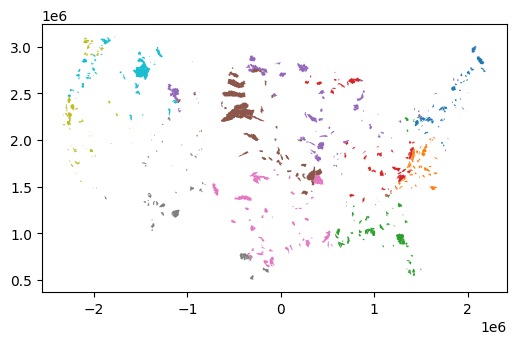

In [19]:
regions_df = CAMELS_basins
region_name = 'name'
regions_df.plot(column=region_name, figsize=(6,4))

Coordinate reference system setting up

In [20]:
regions_df = regions_df.to_crs('EPSG:4326')

In [21]:
crs_orig =  regions_df.crs

In [22]:
x = 'x'  # projected x coordinate name
y = 'y'  # projected y coordinate name

Projection to Lambert Comformal

In [23]:
ds = Runoff_CONUS404
crs_info = ds.crs
xx = ds.x.values
yy = ds.y.values
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = ccrs.LambertConformal(globe=globe,
                            central_longitude=crs_info.longitude_of_central_meridian, 
                            central_latitude=crs_info.latitude_of_projection_origin,
                            standard_parallels=crs_info.standard_parallel)

lcc_wkt = lcc.to_wkt()

regions_df = regions_df.to_crs(lcc_wkt)

**Spatial aggregation**

Bounding box for computational boundaries definition 

In [24]:
bbox = tuple(regions_df.total_bounds)
bbox

(-2154562.0379424603,
 -1276762.9952855927,
 2300165.6573961778,
 1283587.491455175)

Slicing using the bounding box

In [25]:
ds = ds.sel(x=slice(bbox[0],bbox[2]), y=slice(bbox[1],bbox[3]))

Band and gridding

In [26]:
var = "Runoff"

In [27]:
grid = ds[[var]].drop(['time', var]).reset_coords().load()

C:\Users\adi10136\AppData\Local\Temp\ipykernel_37120\14430581.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  grid = ds[[var]].drop(['time', var]).reset_coords().load()


In [28]:
grid = grid.cf.add_bounds([x, y]) 

In [29]:
points = grid.stack(point=(y,x))

Bounds conversion to polygon

In [30]:
def bounds_to_poly(x_bounds, y_bounds):
    return Polygon([
        (x_bounds[0], y_bounds[0]),
        (x_bounds[0], y_bounds[1]),
        (x_bounds[1], y_bounds[1]),
        (x_bounds[1], y_bounds[0])
    ])

In [31]:
%%time
boxes = xr.apply_ufunc(
    bounds_to_poly,
    points.x_bounds,
    points.y_bounds,
    input_core_dims=[("bounds",),  ("bounds",)],
    output_dtypes=[np.dtype('O')],
    vectorize=True
)

CPU times: total: 17.1 s
Wall time: 17.9 s


In [32]:
grid_df= gpd.GeoDataFrame(
    data={"geometry": boxes.values, "y": boxes[y], "x": boxes[x]},
    index=boxes.indexes["point"],
    crs=lcc_wkt
)

In [33]:
crs_area = "EPSG:6931"

regions_df = regions_df.to_crs(crs_area)
grid_df = grid_df.to_crs(crs_area)

grid_df.crs

<Projected CRS: EPSG:6931>
Name: WGS 84 / NSIDC EASE-Grid 2.0 North
Axis Info [cartesian]:
- X[south]: Easting (metre)
- Y[south]: Northing (metre)
Area of Use:
- name: Northern hemisphere.
- bounds: (-180.0, 0.0, 180.0, 90.0)
Coordinate Operation:
- name: US NSIDC EASE-Grid 2.0 North
- method: Lambert Azimuthal Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
overlay = grid_df.overlay(regions_df, keep_geom_type=True)

In [35]:
overlay.geometry.area.groupby(overlay[region_name]).sum().nlargest(10)/1e6  # km2
regions_df.geometry.area.groupby(regions_df[region_name]).sum().nlargest(10)

name
06452000    2.554604e+10
13340000    1.427006e+10
06447000    1.272204e+10
06360500    1.266154e+10
06354000    1.053560e+10
06934000    8.264160e+09
06441500    8.136464e+09
06191500    6.782220e+09
07301500    6.253081e+09
05057000    6.173869e+09
dtype: float64

In [36]:
grid_cell_fraction = overlay.geometry.area.groupby(overlay[region_name]).transform(lambda x: x / x.sum())
grid_cell_fraction
grid_cell_fraction.groupby(overlay[region_name]).sum()

name
01013500    1.0
01022500    1.0
01030500    1.0
01031500    1.0
01047000    1.0
           ... 
14309500    1.0
14316700    1.0
14325000    1.0
14362250    1.0
14400000    1.0
Length: 670, dtype: float64

In [37]:
multi_index = overlay.set_index([y, x, region_name]).index
df_weights = pd.DataFrame({"weights": grid_cell_fraction.values}, index=multi_index)

In [38]:
ds_weights = xr.Dataset(df_weights)

Aggregate duplicate entries by taking the mean (or sum, as required)

In [39]:
ds_weights_aggregated = ds_weights.groupby('dim_0').mean()

Proceed with unstacking

In [40]:
weights_sparse = ds_weights_aggregated.unstack(sparse=True, fill_value=0.)
weights_sparse = weights_sparse.weights

Sparse the matrix

In [41]:
def apply_weights_matmul_sparse(weights, data):

    assert isinstance(weights, sparse.SparseArray)
    assert isinstance(data, np.ndarray)
    data = sparse.COO.from_numpy(data)
    data_shape = data.shape
    # k = nlat * nlon
    n, k = data_shape[0], data_shape[1] * data_shape[2]
    data = data.reshape((n, k))
    weights_shape = weights.shape
    k_, m = weights_shape[0] * weights_shape[1], weights_shape[2]
    assert k == k_
    weights_data = weights.reshape((k, m))

    regridded = sparse.matmul(data, weights_data)
    assert regridded.shape == (n, m)
    return regridded.todense()

In [42]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    var_regridded = xr.apply_ufunc(
        apply_weights_matmul_sparse,
        weights_sparse,
        ds[var],
        join="left",
        input_core_dims=[[y, x, region_name], [y, x]],
        output_core_dims=[[region_name]],
        dask="parallelized",
        dask_gufunc_kwargs=dict(meta=[np.ndarray((0,))])
    )


var_regridded.compute()

CPU times: total: 3.77 s
Wall time: 4.49 s


<xarray.DataArray (time: 21, name: 670)> Size: 113kB
array([[ 508.60785238,  616.77081631,  573.40067544, ...,  844.07850621,
         175.1567117 , 1369.06771757],
       [ 683.96276901,  854.94928144,  813.61170095, ...,  780.64312584,
         155.62229348, 1260.57712231],
       [ 620.93703532,  685.05455863,  657.61161361, ...,  713.00097794,
         138.382986  , 1170.73780922],
       ...,
       [ 779.34569744,  721.96416502,  690.21337374, ..., 1143.09418496,
         246.41786031, 1821.0098905 ],
       [ 749.23912784,  819.06211812,  769.99278708, ..., 1000.85316516,
         238.028346  , 1538.35008897],
       [ 593.21921621,  857.27396827,  719.18829198, ..., 1012.38789506,
         206.66637016, 1594.4125568 ]])
Coordinates:
  * name       (name) object 5kB '01013500' '01022500' ... '14362250' '14400000'
  * time       (time) datetime64[ns] 168B 1990-10-01 1991-10-01 ... 2010-10-01
    metpy_crs  object 8B Projection: lambert_conformal_conic
    crs        int32 4B 0

Runoff Plot

In [43]:
ds_var = var_regridded.sel(name = gage_ids).to_dataset(region_name)

In [44]:
ds_var.hvplot(x='time', grid=True, frame_width=1000, title='Runoff') 

:NdOverlay   [Variable]
   :Curve   [time]   (value)

In [45]:
df_mean = var_regridded.sel(name= gage_ids).to_pandas().max()
df_mean.name = var
df_mean = pd.DataFrame(df_mean).reset_index()
print(df_mean.columns)

Index(['name', 'Runoff'], dtype='object')


In [46]:
merged = pd.merge(regions_df, df_mean)

In [47]:
crs_geo = 'EPSG:4326'

In [48]:
merged_geo = merged.to_crs(crs_geo)

In [49]:
merged_geo.hvplot(c=var, geo=True, cmap='viridis_r', frame_width=1000, tiles='OpenTopoMap', title='CAMELS_Runoff_CONUS404', alpha=0.3)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (Runoff)

**CAMELS runoff data from CONUS404 to CSV file**

In [10]:
var_regridded.name = var
CAMELS_Runoff = var_regridded.sel(name = gage_ids)
CAMELS_Runoff = CAMELS_Runoff.sel(time=slice('1989-10-01','2010-09-30')) #.resample(time="Y").sum()
CAMELS_Runoff = CAMELS_Runoff.to_dataframe().reset_index()

df_squaw_creek_Q_data = CAMELS_Runoff
CAMELS_Runoff

NameError: name 'var' is not defined

In [51]:
CAMELS_Runoff.to_csv('CAMELS_runoff_CONUS404_2X.csv')

#### **Reading USGS stream data from NLDI**

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01013500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01013500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01022500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01022500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01030500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01030500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01031500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01031500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01047000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01047000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01052500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 334 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01440000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01440000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 334 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01440400&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01440400
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01451800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01451800
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(
It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(
It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minu

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01466500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01466500
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01484100&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01484100
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01485500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01485500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01486000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01486000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01487000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01487000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01491000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 01491000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01510000&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 3 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02064000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02064000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 3 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02065500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02065500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02069700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02069700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02070000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02070000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02074500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02074500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02077200&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02077200
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02081500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 7 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02082950&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02082950
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 7 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02092500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02092500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02096846&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02096846
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02102908&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02102908
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02108000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02108000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02111180&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02111180
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02111500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 3 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02215100&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02215100
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 3 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02216180&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02216180
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02221525&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02221525
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02231000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02231000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02231342&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02231342
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02235200&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02235200
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02245500&startDT=1989

It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02300700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02300700
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02310947&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02310947
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02312200&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02312200
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02314500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02314500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02315500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02315500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02324400&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 02324400
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=02327100&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 64 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06470800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06470800
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 64 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06477500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06477500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06479215&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06479215
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06479438&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06479438
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06601000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06601000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06614800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06614800
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06622700&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06814000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06814000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06847900&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06847900
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06853800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06853800
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06876700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06876700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06878000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06878000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06879650&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 06879650
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=06885500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 10 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07067000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07067000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 10 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07068000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07068000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07071500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07071500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07083000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07083000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07142300&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07142300
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07145700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07145700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07148400&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4746 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07299670&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07299670
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4746 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07301410&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07301410
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07301500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07301500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07315200&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07315200
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07315700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07315700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07335700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 07335700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=07340300&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08013000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08013000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08014500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08014500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08023080&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08023080
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08025500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08025500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08029500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08029500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08050800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08050800
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08066200&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08079600&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08079600
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 4 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08082700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08082700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08086212&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08086212
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08086290&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08086290
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08101000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08101000
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 23 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08103900&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08103900
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 23 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08104900&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08104900
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08109700&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08109700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08150800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08150800
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08155200&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08155200
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(
It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(
It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minu

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08158700&startDT=1989-10-01&endDT=2010-09-30


C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:102: HydroUserWarning: It is not possible to determine the frequency for one of the datasets in this request. This dataset will be set to a frequency of 0 minutes
  warnings.warn(


Successfully processed data for Gage ID: 08158700
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08158810&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08158810
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08164000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08164000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08164300&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08164300
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08164600&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08164600
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=08165300&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 08165300
Requested data from https://waterservices.usgs.gov/nwis

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336660&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 10336660
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10336740&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 10336740
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10343500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 10343500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10348850&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 10348850
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=10396000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 10396000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11098000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11098000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11124500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 11 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11180960&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11180960
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 11 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11224500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11224500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11230500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11230500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11237500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11237500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11253310&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11253310
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11264500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 11264500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=11266500&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 10 days 00:00:00


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12175500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12175500
Requesting data from https://waterservices.usgs.gov/nwis/dv/?...

C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 10 days 00:00:00
  warnings.warn(


Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12178100&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12178100
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12186000&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12186000
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12189500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12189500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12358500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12358500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12374250&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 12374250
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=12375900&startDT=1989

One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00
C:\Users\adi10136\AppData\Local\anaconda3\envs\CONUS404_test\lib\site-packages\hydrofunctions\hydrofunctions.py:596: HydroUserWarning: One or more datasets in this request is going to be 'upsampled' to 1 days 00:00:00 because the data were collected at a lower frequency of 2 days 00:00:00
  warnings.warn(


Successfully processed data for Gage ID: 14138870
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=14138900&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 14138900
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=14139800&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 14139800
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=14141500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 14141500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=14154500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 14154500
Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=14158500&startDT=1989-10-01&endDT=2010-09-30
Successfully processed data for Gage ID: 14158500
Requested data from https://waterservices.usgs.gov/nwis

C:\Users\adi10136\AppData\Local\Temp\ipykernel_37120\3727845348.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


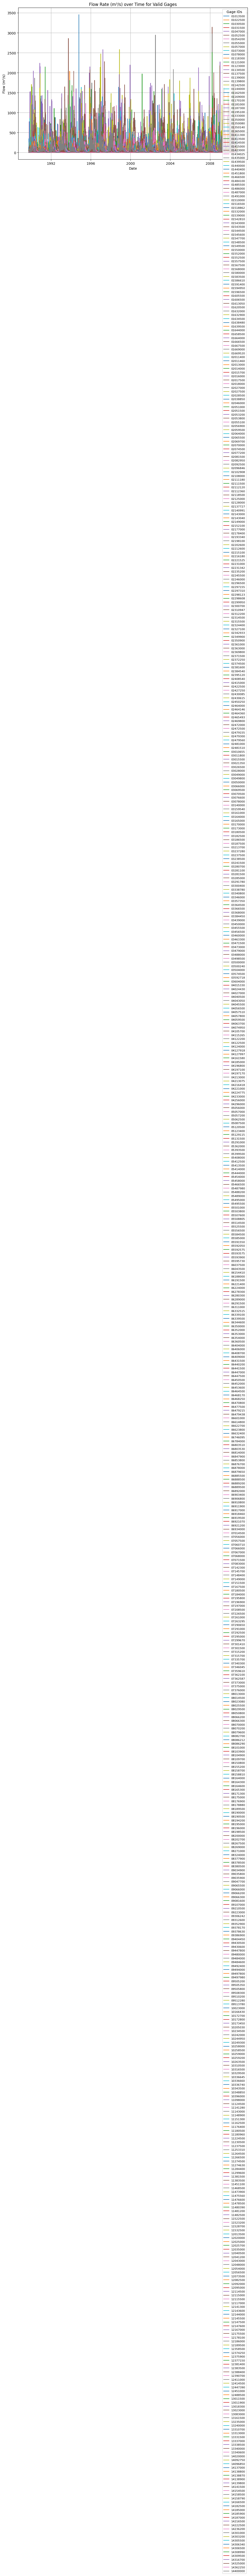

Problematic Gages: ['02196000', '12010000']
Working Gages: ['01013500', '01022500', '01030500', '01031500', '01047000', '01052500', '01054200', '01055000', '01057000', '01073000', '01078000', '01118300', '01121000', '01123000', '01134500', '01137500', '01139000', '01139800', '01142500', '01144000', '01162500', '01169000', '01170100', '01181000', '01187300', '01195100', '01333000', '01350000', '01350080', '01350140', '01365000', '01411300', '01413500', '01414500', '01415000', '01423000', '01434025', '01435000', '01439500', '01440000', '01440400', '01451800', '01466500', '01484100', '01485500', '01486000', '01487000', '01491000', '01510000', '01516500', '01518862', '01532000', '01539000', '01542810', '01543000', '01543500', '01544500', '01545600', '01547700', '01548500', '01549500', '01550000', '01552000', '01552500', '01557500', '01567500', '01568000', '01580000', '01583500', '01586610', '01591400', '01594950', '01596500', '01605500', '01606500', '01613050', '01620500', '01632000', '016

In [52]:
# List of USGS gage IDs
gage_ids = ['01013500', '01022500', '01030500', '01031500', '01047000', '01052500', '01054200', '01055000', '01057000',
    '01073000', '01078000', '01118300', '01121000', '01123000', '01134500', '01137500', '01139000', '01139800',
    '01142500', '01144000', '01162500' , '01169000', '01170100', '01181000', '01187300', '01195100', '01333000',
    '01350000', '01350080', '01350140', '01365000', '01411300', '01413500', '01414500', '01415000', '01423000',
    '01434025', '01435000', '01439500', '01440000', '01440400', '01451800', '01466500', '01484100', '01485500',
    '01486000', '01487000', '01491000', '01510000', '01516500', '01518862', '01532000', '01539000', '01542810',
    '01543000', '01543500', '01544500', '01545600', '01547700', '01548500', '01549500', '01550000', '01552000',
    '01552500', '01557500', '01567500', '01568000', '01580000', '01583500', '01586610', '01591400', '01594950',
    '01596500', '01605500', '01606500', '01613050', '01620500', '01632000', '01632900', '01634500', '01638480',
    '01639500', '01644000', '01658500', '01664000', '01666500', '01667500', '01669000', '01669520', '02011400',
    '02011460', '02013000', '02014000', '02015700', '02016000', '02017500', '02018000', '02027000', '02027500',
    '02028500', '02038850', '02046000', '02051000', '02051500', '02053200', '02053800', '02055100', '02056900',
    '02059500', '02064000', '02065500', '02069700', '02070000', '02074500', '02077200', '02081500', '02082950',
    '02092500', '02096846', '02102908', '02108000', '02111180', '02111500', '02112120', '02112360', '02118500',
    '02125000', '02128000', '02137727', '02140991', '02143000', '02143040', '02149000', '02152100', '02177000',
    '02178400', '02193340', '02196000', '02198100', '02202600', '02212600', '02215100', '02216180', '02221525',
    '02231000', '02231342', '02235200', '02245500', '02246000', '02296500', '02297155', '02297310', '02298123',
    '02298608', '02299950', '02300700', '02310947', '02312200', '02314500', '02315500', '02324400', '02327100',
    '02342933', '02349900', '02350900', '02361000', '02363000', '02369800', '02371500', '02372250', '02374500',
    '02381600', '02384540', '02395120', '02408540', '02415000', '02422500', '02427250', '02430085', '02430615',
    '02450250', '02464000', '02464146', '02464360', '02465493', '02469800', '02472000', '02472500', '02479155',
    '02479300', '02479560', '02481000', '02481510', '03010655', '03011800', '03015500', '03021350', '03026500',
    '03028000', '03049000', '03049800', '03050000', '03066000', '03069500', '03070500', '03076600', '03078000',
    '03140000', '03159540', '03161000', '03164000', '03165000', '03170000', '03173000', '03180500',
    '03182500', '03186500', '03187500', '03213700', '03237280', '03237500', '03238500', '03241500', '03280700',
    '03281100', '03281500', '03285000', '03291780', '03300400', '03338780', '03340800', '03346000', '03357350',
    '03364500', '03366500', '03368000', '03384450', '03439000', '03450000', '03455500', '03456500', '03460000',
    '03463300', '03471500', '03473000', '03479000', '03488000', '03498500', '03500000', '03500240', '03504000',
    '03574500', '03592718', '03604000', '04015330', '04024430', '04027000', '04040500', '04043050', '04045500',
    '04056500', '04057510', '04057800', '04059500', '04063700', '04074950', '04105700', '04115265', '04122200',
    '04122500', '04124000', '04127918', '04127997', '04161580', '04185000', '04196800', '04197100', '04197170',
    '04213000', '04213075', '04216418', '04221000', '04224775', '04233000', '04256000', '04296000', '05056000',
    '05057000', '05057200', '05062500', '05087500', '05120500', '05123400', '05129115', '05131500', '05291000',
    '05362000', '05393500', '05399500', '05408000', '05412500', '05413500', '05414000', '05444000', '05454000',
    '05458000', '05466500', '05487980', '05488200', '05489000', '05495000', '05495500', '05501000', '05503800',
    '05507600', '05508805', '05514500', '05525500', '05556500', '05584500', '05585000', '05591550', '05592050',
    '05592575', '05593575', '05593900', '05595730', '06037500', '06043500', '06154410', '06188000', '06191500',
    '06221400', '06224000', '06278300', '06280300', '06289000', '06291500', '06311000', '06332515', '06339100',
    '06339500', '06344600', '06350000', '06352000', '06353000', '06354000', '06360500', '06404000', '06406000',
    '06408700', '06409000', '06431500', '06440200', '06441500', '06447000', '06447500', '06450500', '06452000',
    '06453600', '06464500', '06468170', '06468250', '06470800', '06477500', '06479215', '06479438',
    '06601000', '06614800', '06622700', '06623800', '06632400', '06746095', '06784000', '06803510', '06803530', '06814000',
    '06847900', '06853800', '06876700', '06878000', '06879650', '06885500', '06888500', '06889200', '06889500', '06892000',
    '06903400', '06906800', '06910800', '06911900', '06917000', '06918460', '06919500', '06921070', '06921200', '06934000',
    '07014500', '07056000', '07057500', '07060710', '07066000', '07067000', '07068000', '07071500', '07083000', '07142300',
    '07145700', '07148400', '07149000', '07151500', '07167500', '07180500', '07184000', '07195800', '07196900', '07197000',
    '07208500', '07226500', '07261000', '07263295', '07290650', '07291000', '07292500', '07295000', '07299670', '07301410',
    '07301500', '07315200', '07315700', '07335700', '07340300', '07346045', '07359610', '07362100', '07362587', '07373000',
    '07375000', '07376000', '08013000', '08014500', '08023080', '08025500', '08029500', '08050800', '08066200', '08066300',
    '08070000', '08070200', '08079600', '08082700', '08086212', '08086290', '08101000', '08103900', '08104900', '08109700',
    '08150800', '08155200', '08158700', '08158810', '08164000', '08164300', '08164600', '08165300', '08171300', '08175000',
    '08176900', '08178880', '08189500', '08190000', '08190500', '08194200', '08195000', '08196000', '08198500', '08200000',
    '08202700', '08267500', '08269000', '08271000', '08324000', '08377900', '08378500', '08380500', '09034900', '09035800',
    '09035900', '09047700', '09065500', '09066000', '09066200', '09066300', '09081600', '09107000', '09210500', '09223000',
    '09306242', '09312600', '09352900', '09378170', '09378630', '09386900', '09404450', '09430500', '09430600', '09447800',
    '09480000', '09484000', '09484600', '09492400', '09494000', '09497800', '09497980', '09505200', '09505350', '09505800',
    '09508300', '09510200', '09512280', '09513780', '10023000', '10166430', '10172700', '10172800', '10173450', '10205030',
    '10234500', '10242000', '10244950', '10249300', '10258000', '10258500', '10259000', '10259200', '10263500', '10310500',
    '10316500', '10329500', '10336645', '10336660', '10336740', '10343500', '10348850', '10396000', '11098000', '11124500',
    '11141280', '11143000', '11148900', '11151300', '11162500', '11176400', '11180500', '11180960', '11224500', '11230500',
    '11237500', '11253310', '11264500', '11266500', '11274500', '11274630', '11284400', '11299600', '11381500', '11383500',
    '11451100', '11468500', '11473900', '11475560', '11476600', '11478500', '11480390', '11481200', '11482500', '11522500',
    '11523200', '11528700', '11532500', '12010000', '12013500', '12020000', '12025000', '12025700', '12035000', '12040500',
    '12041200', '12043000', '12048000', '12054000', '12056500', '12073500', '12082500', '12092000', '12095000', '12114500',
    '12115000', '12115500', '12117000', '12141300', '12143600', '12144000', '12145500', '12147500', '12147600', '12167000',
    '12175500', '12178100', '12186000', '12189500', '12358500', '12374250', '12375900', '12377150', '12381400', '12383500',
    '12388400', '12390700', '12411000', '12414500', '12447390', '12451000', '12488500', '13011500', '13011900', '13018300',
    '13023000', '13083000', '13161500', '13235000', '13240000', '13310700', '13313000', '13331500', '13337000', '13338500',
    '13340000', '13340600', '14020000', '14092750', '14096850', '14137000', '14138800', '14138870', '14138900', '14139800',
    '14141500', '14154500', '14158500', '14158790', '14166500', '14182500', '14185000', '14185900', '14187000', '14216500',
    '14222500', '14236200', '14301000', '14303200', '14305500', '14306340', '14306500', '14308990', '14309500', '14316700',
    '14325000', '14362250', '14400000'
]

# Date range for the flow data
start_date = '1989-10-01'
end_date = '2010-09-30'

# Initialize an empty DataFrame to store all gages' data
all_gages_df = pd.DataFrame()

# List to track problematic gage IDs
problematic_gages = []

# Iterate over each gage ID and retrieve its flow data
for gage_id in gage_ids:
    try:
        # Retrieve daily flow data for the specified date range
        flow_data = hf.NWIS(gage_id, 'dv', start_date=start_date, end_date=end_date)
        df = flow_data.df()
        
        # Convert the index to pandas datetime format
        df.index = pd.to_datetime(df.index, errors='coerce')

        # Select the specific column for flow (USGS:gauge_id:00060:00003) and convert to m³/s
        column_name = f'USGS:{gage_id}:00060:00003'
        if column_name in df.columns:
            df[f'{gage_id}'] = df[column_name] * 0.028316  # Conversion factor from ft³/s to m³/s
            all_gages_df = pd.concat([all_gages_df, df[f'{gage_id}']], axis=1)
            print(f"Successfully processed data for Gage ID: {gage_id}")
        else:
            print(f"Column {column_name} not found for Gage ID: {gage_id}")
            problematic_gages.append(gage_id)
    except Exception as e:
        if "upsampled" in str(e):
            print(f"Gage ID {gage_id}: {e} (Upsampled warning)")
        else:
            print(f"Error processing Gage ID {gage_id}: {e}")
        problematic_gages.append(gage_id)

# Remove problematic gage IDs from the list
working_gages = [gage_id for gage_id in gage_ids if gage_id not in problematic_gages]

# Plot the data for working gages
plt.figure(figsize=(12, 8))
for gage_id in working_gages:
    if gage_id in all_gages_df.columns:
        plt.plot(all_gages_df.index, all_gages_df[gage_id], label=gage_id)

# Add labels, title, and legend
plt.title('Flow Rate (m³/s) over Time for Valid Gages')
plt.xlabel('Date')
plt.ylabel('Flow (m³/s)')
plt.legend(title="Gage IDs", loc='upper right', fontsize=8)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

print(f"Problematic Gages: {problematic_gages}")
print(f"Working Gages: {working_gages}")


In [53]:
all_gages_df
# all_gages_df.to_csv("(CAMELS_USGS_dataDV).csv", index=False)

01013500  01022500   01030500  01031500  \
1989-10-01 00:00:00+00:00   8.494800  4.219084  31.997080  5.889728   
1989-10-02 00:00:00+00:00   8.409852  3.766028  28.882320  5.068564   
1989-10-03 00:00:00+00:00   8.862908  4.842036  26.503776  5.096880   
1989-10-04 00:00:00+00:00   8.381536  5.493304  24.748184  5.210144   
1989-10-05 00:00:00+00:00   8.098376  5.011932  23.162488  4.587192   
...                              ...       ...        ...       ...   
2010-09-26 00:00:00+00:00  16.989600  1.931151  11.751140  3.397920   
2010-09-27 00:00:00+00:00  16.593176  1.778245  14.696004  2.817442   
2010-09-28 00:00:00+00:00  18.093924  1.789571  16.281700  2.888232   
2010-09-29 00:00:00+00:00  21.293632  2.047247  16.961284  4.190768   
2010-09-30 00:00:00+00:00  24.380076  2.129363  17.640868  4.077504   

                            01047000   01052500   01054200  01055000  \
1989-10-01 00:00:00+00:00   8.070060   3.426236   0.991060  2.576756   
1989-10-02 00:00:00+00:00   7.617004   3.143076   0.991060  2.463492   
1989-10-03 00:00:00+00:00   8.466484   3.709396   2.916548  7.079000   
1989-10-04 00:00:00+00:00   9.089436   3.907608   1.897172  4.757088   
1989-10-05 00:00:00+00:00   7.956796   3.369604   1.444116  3.652764   
...                              ...        ...        ...       ...   
2010-09-26 00:00:00+00:00   5.634884   3.341288   0.724890  1.158124   
2010-09-27 00:00:00+00:00   4.643824   2.579588   0.764532  1.098661   
2010-09-28 00:00:00+00:00   6.569312   6.767524   2.027426  4.700456   
2010-09-29 00:00:00+00:00  12.572304  21.718372   5.125196  7.532056   
2010-09-30 00:00:00+00:00  20.047728  25.314504  13.903156  9.315964   

                           01057000  01073000  ...  14303200   14305500  \
1989-10-01 00:00:00+00:00  0.849480  0.158570  ...  0.033979   3.907608   
1989-10-02 00:00:00+00:00  0.736216  0.152906  ...  0.031148   3.001496   
1989-10-03 00:00:00+00:00  2.265280  0.283160  ...  0.031148   2.576756   
1989-10-04 00:00:00+00:00  1.840540  0.218033  ...  0.031148   2.378544   
1989-10-05 00:00:00+00:00  1.359168  0.181222  ...  0.031148   2.378544   
...                             ...       ...  ...       ...        ...   
2010-09-26 00:00:00+00:00  0.382266  0.014724  ...  0.072206   7.362160   
2010-09-27 00:00:00+00:00  0.342624  0.014441  ...  0.073055  10.023864   
2010-09-28 00:00:00+00:00  0.489867  0.021237  ...  0.062295   8.155008   
2010-09-29 00:00:00+00:00  0.668258  0.037094  ...  0.058048   7.333844   
2010-09-30 00:00:00+00:00  0.699405  0.029165  ...  0.055216   6.739208   

                           14306340  14306500  14308990  14309500  14316700  \
1989-10-01 00:00:00+00:00  0.053800  3.029812  0.424740  0.481372  2.067068   
1989-10-02 00:00:00+00:00  0.039642  2.774968  0.368108  0.368108  1.840540   
1989-10-03 00:00:00+00:00  0.033979  2.435176  0.311476  0.311476  1.585696   
1989-10-04 00:00:00+00:00  0.027183  2.265280  0.271834  0.283160  1.472432   
1989-10-05 00:00:00+00:00  0.023219  2.180332  0.263339  0.277497  1.415800   
...                             ...       ...       ...       ...       ...   
2010-09-26 00:00:00+00:00  0.041341  3.794344  0.305813  0.251163  1.526232   
2010-09-27 00:00:00+00:00  0.044739  3.850976  0.294486  0.242668  1.455442   
2010-09-28 00:00:00+00:00  0.043040  3.737712  0.285992  0.235023  1.410137   
2010-09-29 00:00:00+00:00  0.043323  3.539500  0.297318  0.228510  1.376158   
2010-09-30 00:00:00+00:00  0.042474  3.397920  0.297318  0.226811  1.339347   

                           14325000  14362250  14400000  
1989-10-01 00:00:00+00:00  0.821164  0.024918  2.491808  
1989-10-02 00:00:00+00:00  0.764532  0.021803  2.265280  
1989-10-03 00:00:00+00:00  0.679584  0.020388  2.123700  
1989-10-04 00:00:00+00:00  0.622952  0.019538  2.010436  
1989-10-05 00:00:00+00:00  0.594636  0.016990  1.982120  
...                             ...       ...       ...  
2010-09-26 00:00:00+00:00  1.070345  0.003681  3.82266

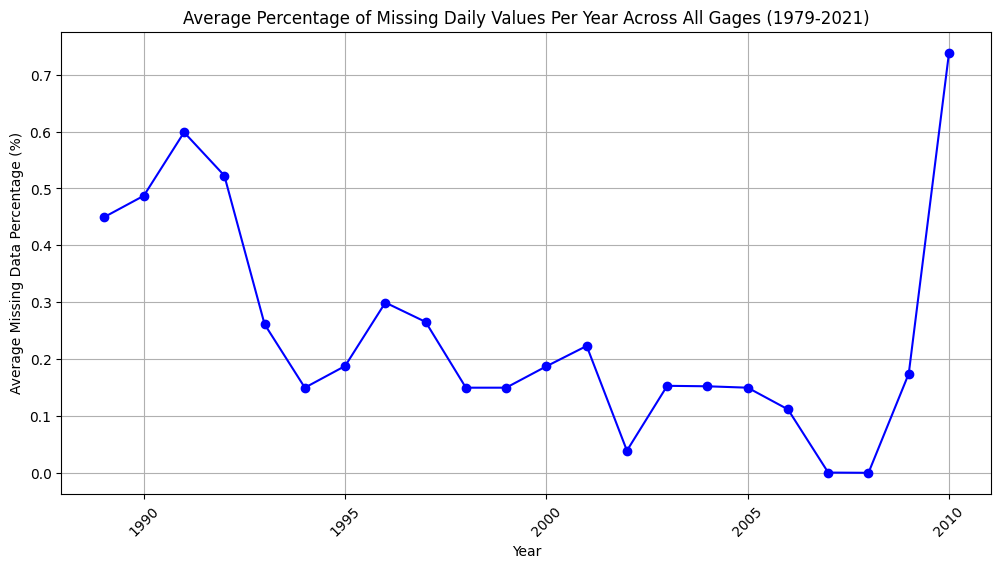

In [54]:
# Manually set the index to the expected date range
expected_date_range = pd.date_range(start="1989-10-01", end="2010-09-30", freq="D")

# Ensure the number of rows matches the expected date range
if len(expected_date_range) == all_gages_df.shape[0]:
    all_gages_df.index = expected_date_range
else:
    print("Warning: The number of rows does not match the expected date range!")

# Recompute the percentage of missing values per year across all gages
missing_percentage_by_year = all_gages_df.isna().mean(axis=1) * 100

# Group by year and compute the average missing percentage across all gages
average_missing_percentage_by_year = missing_percentage_by_year.resample('YE').mean()

# Plot the corrected results
plt.figure(figsize=(12, 6))
plt.plot(average_missing_percentage_by_year.index.year, average_missing_percentage_by_year, marker='o', linestyle='-', color='b')

# Formatting the plot
plt.xlabel("Year")

plt.ylabel("Average Missing Data Percentage (%)")
plt.title("Average Percentage of Missing Daily Values Per Year Across All Gages (1979-2021)")
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [55]:
import pandas as pd

# Assuming 'all_gages_df' is already loaded

# Count NaN values for each column (gage)
nan_counts = all_gages_df.isna().sum()

# Total number of daily values per column (gage)
total_values_per_gage = all_gages_df.shape[0]

# Calculate percentage of missing values for each gage
missing_percentage_per_gage = (nan_counts / total_values_per_gage) * 100

# Create a DataFrame with the results
missing_data_summary = pd.DataFrame({
    "Gage_ID": all_gages_df.columns,
    "NaN Count": nan_counts.values,
    "Total Values": total_values_per_gage,
    "Missing Percentage (%)": missing_percentage_per_gage.values
})

# Save the results to a CSV file
missing_data_summary.to_csv("Gage_data_Checking(CAMELS).csv", index=False)

# Display the first few rows of the DataFrame
print(missing_data_summary.head())



    Gage_ID  NaN Count  Total Values  Missing Percentage (%)
0  01013500          0          7670                     0.0
1  01022500          0          7670                     0.0
2  01030500          0          7670                     0.0
3  01031500          0          7670                     0.0
4  01047000          0          7670                     0.0


In [56]:
# Ensure the index is in datetime format
all_gages_df.index = pd.to_datetime(all_gages_df.index, errors='coerce')

# Resample the data to annual frequency and calculate the mean for each year
annual_flows = all_gages_df.resample("AS-OCT", label="right").mean()

C:\Users\adi10136\AppData\Local\Temp\ipykernel_37120\1506823442.py:5: FutureWarning: 'AS-OCT' is deprecated and will be removed in a future version, please use 'YS-OCT' instead.
  annual_flows = all_gages_df.resample("AS-OCT", label="right").mean()


CAMELS Basins Area

In [57]:
# Ensure the number of gage IDs matches the number of rows in your GeoDataFrame
if len(CAMELS_basins) == len(gage_ids):
    CAMELS_basins['name'] = gage_ids
else:
    raise ValueError("The number of gage IDs does not match the number of features in the shapefile.")

# Reproject to a projected CRS (e.g., EPSG:3857) for accurate area calculations
if CAMELS_basins.crs.is_geographic:
    CAMELS_basins = CAMELS_basins.to_crs(epsg=5070)  # Use Web Mercator or another suitable projected CRS

# Calculate the area in square meters and add it as a new column
CAMELS_basins['Area_sqm'] = CAMELS_basins.geometry.area

Datasets aligment (CONUS404 - USGS)

In [58]:
# Ensure the names in 'CAMELS_basins' match the columns in 'annual_flows'
CAMELS_basins = CAMELS_basins.set_index('name')  # Set gage names as the index for easy matching

# Initialize an empty DataFrame to store annual runoff data
annual_runoff_df = pd.DataFrame()

# Iterate over each gage in the 'annual_flows' DataFrame
for gage_id in annual_flows.columns:
    # Check if the gage ID exists in the huc10_basins DataFrame
    if gage_id in CAMELS_basins.index:
        try:
            # Get the watershed area in square meters for the current gage
            W_A = float(CAMELS_basins.loc[gage_id, 'Area_sqm'])  # Ensure scalar value
            
            # Calculate annual runoff (mm/year) for the gage
            annual_flow = annual_flows[gage_id]  # Annual mean flow (m³/s)
            Annual_Runoff = ((annual_flow.values * 86400 * 365) / W_A) * 1000  # Ensure 1D array
            
            # Create a DataFrame for the current gage's runoff data
            runoff_data = pd.DataFrame({
                'Year': annual_flows.index,  # Use the index (year) from the annual_flows DataFrame
                'Runoff_mm': Annual_Runoff,
                'Gage_ID': gage_id
            })
            
            # Append the gage's runoff data to the final DataFrame
            annual_runoff_df = pd.concat([annual_runoff_df, runoff_data], ignore_index=True)
        except Exception as e:
            print(f"Error processing Gage ID {gage_id}: {e}")
    else:
        print(f"Gage ID {gage_id} not found in huc10_basins. Skipping.")

# Save the final annual runoff data to a CSV file
annual_runoff_df.to_csv('CAMELS_annual_runoff2X.csv', index=False)

# Display the first few rows of the final DataFrame
print(annual_runoff_df.head())


        Year   Runoff_mm   Gage_ID
0 1990-10-01  474.832501  01013500
1 1991-10-01  781.635865  01013500
2 1992-10-01  635.338678  01013500
3 1993-10-01  481.302659  01013500
4 1994-10-01  721.540193  01013500


Plot runoff data

In [59]:
# Plot the annual runoff for all gages
import plotly.express as px

fig = px.line(
    annual_runoff_df,
    x='Year',
    y='Runoff_mm',
    color='Gage_ID',
    title='Annual Runoff (mm/year) for Each Gage',
    labels={'Runoff_mm': 'Runoff (mm/year)', 'Year': 'Year', 'Gage_ID': 'Watershed (Gage ID)'},
)
fig.update_layout(template='plotly_white')
# fig.show()
# Optionally open the file automatically in the default web browser

# Save the plot to an HTML file and open it in the browser
plot_file = "Annual_Runoff.html"
fig.write_html(plot_file)

import webbrowser
webbrowser.open(plot_file)


True

In [60]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Ensure Gage_ID column exists in both DataFrames
annual_runoff_df.rename(columns={'name': 'Gage_ID'}, inplace=True)
df_squaw_creek_Q_data.rename(columns={'name': 'Gage_ID'}, inplace=True)

# Align both DataFrames to cover the same period (1986-2022) and same Gage_IDs
start_year = '1986-01-01'
end_year = '2022-12-31'

# Filter annual_runoff_df to include only rows in the specified range
annual_runoff_df['Year'] = pd.to_datetime(annual_runoff_df['Year'])
df_squaw_creek_Q_data['time'] = pd.to_datetime(df_squaw_creek_Q_data['time'])

# Filter years and align Gage_IDs
annual_runoff_filtered = annual_runoff_df[
    (annual_runoff_df['Year'] >= start_year) & (annual_runoff_df['Year'] <= end_year)
]

df_squaw_filtered = df_squaw_creek_Q_data[
    (df_squaw_creek_Q_data['time'] >= start_year) & (df_squaw_creek_Q_data['time'] <= end_year)
]

# Get common Gage_IDs
common_gage_ids = set(annual_runoff_filtered['Gage_ID']).intersection(df_squaw_filtered['Gage_ID'])

# Filter both DataFrames to only include common Gage_IDs
annual_runoff_filtered = annual_runoff_filtered[annual_runoff_filtered['Gage_ID'].isin(common_gage_ids)]
df_squaw_filtered = df_squaw_filtered[df_squaw_filtered['Gage_ID'].isin(common_gage_ids)]


In [61]:
# Convert 'Year' to remove timezone and time portion
annual_runoff_filtered['Year'] = annual_runoff_filtered['Year'].dt.tz_localize(None).dt.normalize()


# Convert 'Year' in annual_runoff_filtered to UTC to match the format of df_squaw_filtered
annual_runoff_filtered['Year'] = annual_runoff_filtered['Year'].dt.tz_localize(None)

# Confirm that both columns are now in the same format
print(annual_runoff_filtered['Year'].dtype)
print(df_squaw_filtered['time'].dtype)

datetime64[ns]
datetime64[ns]


df_squaw_filtered

annual_runoff_filtered

In [62]:
# Merge the DataFrames on Gage_ID and Year/Time
aligned_data = pd.merge(
    annual_runoff_filtered,
    df_squaw_filtered,
    left_on=['Gage_ID', 'Year'],
    right_on=['Gage_ID', 'time'],
    how='inner'
)

# Rename columns for clarity
aligned_data.rename(columns={'Runoff_mm': 'Runoff_Annual', 'Runoff': 'Runoff_Squaw'}, inplace=True)

In [63]:
# print(aligned_data)
aligned_data.to_csv('CAMELS_annual_runoffCONUS404-USGS2.csv', index=False)

In [64]:
# Drop rows with NaN values in either 'Runoff_Annual' or 'Runoff_Squaw'
aligned_data = aligned_data.dropna(subset=['Runoff_Annual', 'Runoff_Squaw'])

# # Confirm there are no NaN values left
# print(aligned_data.isnull().sum())


**Individual Scatter plots**

In [65]:
# Function to create scatter plots with linear regression
def plot_scatter_with_regression(data, gage_id, output_folder):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    # Plot scatter and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(X, Y, color='blue', label='Data points')
    plt.plot(X, Y_pred, color='red', label=f'Linear Regression\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')
    plt.title(f'Scatter Plot: {gage_id} (1986-2022)')
    plt.xlabel('Annual Runoff USGS(mm)')
    plt.ylabel('Annual Runoff CONUS404(mm)')
    plt.legend()
    plt.grid(True)
    plt.text(0.05, 0.95, f'R² = {r_squared:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

    # Save the plot in the specified folder
    filename = os.path.join(output_folder, f"{gage_id}_scatter_plot.png")
    plt.savefig(filename, format="png")
    plt.close()  # Close the figure to save memory
    print(f"Scatter plot saved for Gage ID: {gage_id} at {filename}")

# Specify the output folder to store scatter plots
output_folder = "CAMELSX2_Scatter_plots"
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist
            
# Loop through each Gage_ID and save plots
for gage_id in common_gage_ids:
    plot_scatter_with_regression(aligned_data, gage_id, output_folder)

Scatter plot saved for Gage ID: 07373000 at CAMELSX2_Scatter_plots\07373000_scatter_plot.png
Scatter plot saved for Gage ID: 08050800 at CAMELSX2_Scatter_plots\08050800_scatter_plot.png
Scatter plot saved for Gage ID: 02315500 at CAMELSX2_Scatter_plots\02315500_scatter_plot.png
Scatter plot saved for Gage ID: 04057510 at CAMELSX2_Scatter_plots\04057510_scatter_plot.png
Scatter plot saved for Gage ID: 07060710 at CAMELSX2_Scatter_plots\07060710_scatter_plot.png
Scatter plot saved for Gage ID: 03504000 at CAMELSX2_Scatter_plots\03504000_scatter_plot.png
Scatter plot saved for Gage ID: 10263500 at CAMELSX2_Scatter_plots\10263500_scatter_plot.png
Scatter plot saved for Gage ID: 01639500 at CAMELSX2_Scatter_plots\01639500_scatter_plot.png
Scatter plot saved for Gage ID: 08158700 at CAMELSX2_Scatter_plots\08158700_scatter_plot.png
Scatter plot saved for Gage ID: 04213075 at CAMELSX2_Scatter_plots\04213075_scatter_plot.png
Scatter plot saved for Gage ID: 08014500 at CAMELSX2_Scatter_plots\080

**Data frame with values for coefficient of determination**

In [66]:
# List to store results
results = []

# Loop through each Gage_ID and compute regression statistics
for gage_id in common_gage_ids:
    # Filter data for the specific Gage_ID
    gage_data = aligned_data[aligned_data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    r_squared = model.score(X, Y)

    # Store results
    results.append({
        'Gage_ID': gage_id,
        'R_Squared': r_squared,
        'Slope': model.coef_[0],
        'Intercept': model.intercept_
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
csv_filename = "gage_regression_results2X.csv"
results_df.to_csv(csv_filename, index=False)

print(f"CSV file saved as {csv_filename}")
print(results_df.head())  # Display first few rows of the DataFrame

CSV file saved as gage_regression_results2X.csv
    Gage_ID  R_Squared     Slope   Intercept
0  07373000   0.276244  0.593919  204.346418
1  08050800   0.397057  0.362714  222.527382
2  02315500   0.697694  0.779208  192.186525
3  04057510   0.535065  0.963410  119.581577
4  07060710   0.044144  0.182744  259.122074


In [67]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to create scatter plots with linear regression for a single gage
def plot_scatter_with_regression(data, gage_id):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    return gage_id, X, Y, Y_pred, r_squared, model

# Function to create a multi-panel plot for gages with R² > 0.7, remove grid lines, and save as PNG
def plot_filtered_scatter(data, common_gage_ids, output_file='filtered_scatter_plots.png'):
    # Filter gage IDs with R² > 0.7
    filtered_gages = []
    results = []
    
    for gage_id in common_gage_ids:
        gage_id, X, Y, Y_pred, r_squared, model = plot_scatter_with_regression(data, gage_id)
        if r_squared > 0.7:
            filtered_gages.append(gage_id)
            results.append((X, Y, Y_pred, r_squared, gage_id, model))

    # Create a multi-panel figure
    n = len(filtered_gages)
    cols = 2
    rows = (n + 1) // cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axes = axes.flatten() if n > 1 else [axes]

    for i, (X, Y, Y_pred, r_squared, gage_id, model) in enumerate(results):
        ax = axes[i]
        ax.scatter(X, Y, color='blue', label='Data points')
        ax.plot(X, Y_pred, color='red', label=f'Linear Regression\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}')
        ax.set_title(f'{gage_id}: R² = {r_squared:.2f}')
        ax.set_xlabel('Annual Runoff USGS(mm)')
        ax.set_ylabel('Annual Runoff CONUS404(mm)')
        ax.legend()
        # Remove grid lines
        ax.grid(False)

    # Hide unused subplots if any
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    # Adjust layout and save to a file
    plt.tight_layout()
    plt.savefig(output_file, dpi=600)
    plt.close()

    print(f"Scatter plots saved to {output_file}")

# Example usage (Replace `aligned_data` and `common_gage_ids` with your actual data)
plot_filtered_scatter(aligned_data, common_gage_ids, output_file='camelsX2_scatter_plots_filtered.png')


Scatter plots saved to camelsX2_scatter_plots_filtered.png


**Scatter plots filtered by number of points and value for coefficient of determination**

In [69]:
# Adding a filter to include only gages with more than 20 points
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to create scatter plots with linear regression for a single gage
def plot_scatter_with_regression(data, gage_id):
    # Filter data for the specific Gage_ID
    gage_data = data[data['Gage_ID'] == gage_id]

    # Extract X (annual runoff) and Y (squaw creek runoff)
    X = gage_data['Runoff_Annual'].values.reshape(-1, 1)
    Y = gage_data['Runoff_Squaw'].values

    # Perform linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    r_squared = model.score(X, Y)

    return gage_id, X, Y, Y_pred, r_squared, model, len(X)

# Function to create a grid layout of scatter plots with filtering
def plot_scatter_grid(data, common_gage_ids, scatter_width=4, scatter_height=3, output_file='scatterX2CAMELS_grid_poster.png'):
    # Filter gage IDs with R² > 0.7 and more than 20 points
    filtered_gages = []
    results = []
    
    for gage_id in common_gage_ids:
        gage_id, X, Y, Y_pred, r_squared, model, num_points = plot_scatter_with_regression(data, gage_id)
        if r_squared > 0.8 and num_points > 15:  # Apply both filters
            filtered_gages.append(gage_id)
            results.append((X, Y, Y_pred, r_squared, gage_id, model))

    # Determine the number of rows and columns
    n = len(filtered_gages)
    cols = 4  # Adjust as needed for poster layout
    rows = (n + cols - 1) // cols  # Calculate number of rows

    # Set figure size based on scatter plot dimensions
    fig, axes = plt.subplots(rows, cols, figsize=(scatter_width * cols, scatter_height * rows))  # Flexible size
    axes = axes.flatten() if n > 1 else [axes]

    for i, (X, Y, Y_pred, r_squared, gage_id, model) in enumerate(results):
        ax = axes[i]
        ax.scatter(X, Y, color='black', alpha=0.7, s=9, label='Data points')  
        ax.plot(X, Y_pred, color='blue', label=f'Fit: y={model.coef_[0]:.2f}x+{model.intercept_:.2f}')
        ax.plot([min(X), max(X)], [min(X), max(X)], linestyle='--', color='gray', label='1:1 Line')
        ax.set_title(f'Gage: {gage_id}\nR² = {r_squared:.2f}', fontsize=18)
        ax.set_xlabel('USGS Runoff (mm)', fontsize=16)
        ax.set_ylabel('CONUS404 Runoff (mm)', fontsize=16)
        ax.tick_params(axis='y', which='major', labelsize=14) 
        ax.tick_params(axis='x', which='major', labelsize=14)  
        ax.legend(fontsize=12, loc='lower right')  

    # Hide unused subplots if any
    for j in range(len(results), len(axes)):
        axes[j].axis('off')

    # Adjust layout for poster presentation
    plt.tight_layout(pad=2.0)
    plt.savefig(output_file, dpi=600)
    plt.close()

    print(f"Scatter grid saved to {output_file}")

# Example usage (Replace `aligned_data` and `common_gage_ids` with your actual data)
plot_scatter_grid(aligned_data, common_gage_ids, scatter_width=5, scatter_height=4, output_file='CAMELSX2_scatter_grid_poster.png')


Scatter grid saved to CAMELSX2_scatter_grid_poster.png
